### **Importing the required libraries**

In [74]:
!pip install shap
!pip install xgboost
!pip install pyswarms
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder,StandardScaler
import math
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFECV
from xgboost import XGBRegressor
import shap
import pyswarms as ps
from pyswarms.single import GlobalBestPSO
from pyswarms.utils.plotters import plot_cost_history
from warnings import filterwarnings
filterwarnings('ignore')

### **Reading the Data file**

In [75]:
df = pd.read_csv("C:/Users/chhon/Downloads/mw_pw_profiles.csv",low_memory=False)
df.head()

,Unnamed: 0,player_id,match_id,gender,balls_per_over,start_date,series_name,match_type,name_x,runs_scored,...,key_pulse,key_pulse_2,full_name,batting_style,bowling_style,playing_role,teams,fantasy_score_batting,fantasy_score_bowling,fantasy_score_total
0,0,00015688,1158348,female,6,2018-08-21,Botswana Cricket Association Women's T20I Series,T20,M King,10,...,NaN,NaN,NaN,NaN,NaN,NaN,[],5,8,17
1,1,00015688,1182644,female,6,2019-05-05,ICC Women's T20 World Cup Africa Region Qualifier,T20,M King,8,...,NaN,NaN,NaN,NaN,NaN,NaN,[],3,0,7
2,2,00015688,1275107,female,6,2021-09-09,ICC Women's T20 World Cup Africa Region Qualifier,T20,M King,1,...,NaN,NaN,NaN,NaN,NaN,NaN,[],1,0,5
3,3,00015688,1275113,female,6,2021-09-15,ICC Women's T20 World Cup Africa Region Qualifier,T20,M King,0,...,NaN,NaN,NaN,NaN,NaN,NaN,[],0,0,4
4,4,00015688,1275125,female,6,2021-09-14,ICC Women's T20 World Cup Africa Region Qualifier,T20,M King,1,...,NaN,NaN,NaN,NaN,NaN,NaN,[],-5,0,-1


In [76]:
df.columns

Index(['Unnamed: 0', 'player_id', 'match_id', 'gender', 'balls_per_over',
       'start_date', 'series_name', 'match_type', 'name_x', 'runs_scored',
       'player_out', 'balls_faced', 'fours_scored', 'sixes_scored',
       'catches_taken', 'run_out_direct', 'run_out_throw', 'stumpings_done',
       'out_kind', 'dot_balls_as_batsman', 'order_seen', 'balls_bowled',
       'runs_conceded', 'wickets_taken', 'bowled_done', 'lbw_done', 'maidens',
       'dot_balls_as_bowler', 'player_team', 'opposition_team', 'name_y',
       'unique_name', 'key_bcci', 'key_bcci_2', 'key_bigbash', 'key_cricbuzz',
       'key_cricheroes', 'key_crichq', 'key_cricinfo', 'key_cricinfo_2',
       'key_cricinfo_3', 'key_cricingif', 'key_cricketarchive',
       'key_cricketarchive_2', 'key_cricketworld', 'key_nvplay',
       'key_nvplay_2', 'key_opta', 'key_opta_2', 'key_pulse', 'key_pulse_2',
       'full_name', 'batting_style', 'bowling_style', 'playing_role', 'teams',
       'fantasy_score_batting', 'fantasy_sc

### **Removing unnecessary columns**

In [77]:
df.drop(['Unnamed: 0','gender', 'balls_per_over', 'series_name', 'name_x', 'name_y', 'unique_name','key_bcci', 'key_bcci_2', 'key_bigbash', 'key_cricbuzz',
       'key_cricheroes', 'key_crichq', 'key_cricinfo', 'key_cricinfo_2',
       'key_cricinfo_3', 'key_cricingif', 'key_cricketarchive',
       'key_cricketarchive_2', 'key_cricketworld', 'key_nvplay',
       'key_nvplay_2', 'key_opta', 'key_opta_2', 'key_pulse', 'key_pulse_2',
       'full_name', 'batting_style', 'bowling_style', 'playing_role', 'teams', ], axis = 1, inplace = True)
df.columns

Index(['player_id', 'match_id', 'start_date', 'match_type', 'runs_scored',
       'player_out', 'balls_faced', 'fours_scored', 'sixes_scored',
       'catches_taken', 'run_out_direct', 'run_out_throw', 'stumpings_done',
       'out_kind', 'dot_balls_as_batsman', 'order_seen', 'balls_bowled',
       'runs_conceded', 'wickets_taken', 'bowled_done', 'lbw_done', 'maidens',
       'dot_balls_as_bowler', 'player_team', 'opposition_team',
       'fantasy_score_batting', 'fantasy_score_bowling',
       'fantasy_score_total'],
      dtype='object')

### **Preprocessing**

In [78]:
df.isnull().sum()

player_id                0
match_id                 0
start_date               0
match_type               0
runs_scored              0
player_out               0
balls_faced              0
fours_scored             0
sixes_scored             0
catches_taken            0
run_out_direct           0
run_out_throw            0
stumpings_done           0
out_kind                 0
dot_balls_as_batsman     0
order_seen               0
balls_bowled             0
runs_conceded            0
wickets_taken            0
bowled_done              0
lbw_done                 0
maidens                  0
dot_balls_as_bowler      0
player_team              0
opposition_team          0
fantasy_score_batting    0
fantasy_score_bowling    0
fantasy_score_total      0
dtype: int64

### **Sorting according to the start date**

In [79]:
df['start_date'] = pd.to_datetime(df['start_date'], errors='coerce')
df.sort_values(by=['start_date'], inplace=True)
df.reset_index(drop=True, inplace=True)
df

,player_id,match_id,start_date,match_type,runs_scored,player_out,balls_faced,fours_scored,sixes_scored,catches_taken,...,wickets_taken,bowled_done,lbw_done,maidens,dot_balls_as_bowler,player_team,opposition_team,fantasy_score_batting,fantasy_score_bowling,fantasy_score_total
0,f44af07f,63963,2001-12-19,Test,39,1,93,6,0,0,...,0,0,0,2,39,England,India,45,0,49
1,de8cce37,63963,2001-12-19,Test,12,1,18,2,0,1,...,0,0,0,0,0,India,England,14,8,26
2,b6cd714f,63963,2001-12-19,Test,4,1,16,0,0,0,...,4,0,1,5,96,India,England,4,76,84
3,725529bc,63963,2001-12-19,Test,0,1,3,0,0,0,...,0,0,0,3,70,India,England,-4,0,0
4,0184dc35,63963,2001-12-19,Test,3,1,61,0,0,1,...,0,0,0,0,0,India,England,3,14,21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
416707,4e38a3d6,1485778,2025-05-20,T20,4,1,10,0,0,0,...,0,0,0,0,0,Nepal,Thailand,-2,0,2
416708,bd36bc39,1485778,2025-05-20,T20,0,0,0,0,0,0,...,0,0,0,0,8,Thailand,Nepal,0,16,20
416709,f6ddfe08,1485778,2025-05-20,T20,0,0,0,0,0,1,...,0,0,0,0,10,Thailand,Nepal,0,12,16
416710,a2f46292,1473500,2025-05-20,T20,0,0,0,0,0,0,...,0,0,0,0,6,Chennai Super Kings,Rajasthan Royals,0,-4,0


### **Feature Generation (Separate Dataframe)**

**Preprocessing the categorical data**

In [80]:
df_features = df.copy()
lbenc = LabelEncoder()
df_features['player_id'] = lbenc.fit_transform(df_features['player_id'])
df_features = pd.get_dummies(df_features, columns = ['match_type'], drop_first = True, dtype = int)

**Generating some new features**

In [81]:
df_features['strike_rate'] = (df['runs_scored']/df['balls_faced'])*100
df_features['economy_rate'] = (df['runs_conceded']/df['balls_bowled'])*100
df_features['all_rounder']  = (df_features['runs_scored']/50 + df_features['wickets_taken']/5)*36
df_features['impact_bat'] = (df_features['runs_scored']*10 + df_features['fours_scored']*2 + df_features['sixes_scored']*3)/df_features['balls_faced']
df_features['impact_bowl'] = (df_features['runs_conceded']*5 + df_features['dot_balls_as_bowler']*1.5 + df_features['maidens']*3)/df_features['balls_bowled']

**Dropping some more values**

In [82]:
df_features.drop(['runs_conceded','balls_faced','balls_bowled','player_out','out_kind',
                  'dot_balls_as_batsman','dot_balls_as_bowler',
                  'fantasy_score_bowling','fantasy_score_batting'],inplace =True,axis =1)

In [83]:
df_features.columns

Index(['player_id', 'match_id', 'start_date', 'runs_scored', 'fours_scored',
       'sixes_scored', 'catches_taken', 'run_out_direct', 'run_out_throw',
       'stumpings_done', 'order_seen', 'wickets_taken', 'bowled_done',
       'lbw_done', 'maidens', 'player_team', 'opposition_team',
       'fantasy_score_total', 'match_type_MDM', 'match_type_ODI',
       'match_type_ODM', 'match_type_T20', 'match_type_Test', 'strike_rate',
       'economy_rate', 'all_rounder', 'impact_bat', 'impact_bowl'],
      dtype='object')

###**Weighted Moving Average**
WMA (Weighted Moving Average) is a type of moving average that assigns more importance (weight) to recent data points when calculating the average. The weights are the hyperparameters here.

For a data series $ P = [P_1, P_2, ..., P_n]  $ and a window size of $ n $ :

$$
\text{WMA}_t = \frac{\sum_{i=1}^{n} w_i \cdot P_{t - n + i}}{\sum_{i=1}^{n} w_i}
$$

Where:
- $w_i $ are the weights (typically: $ w_i = i $)
- $P_{t - n + i} $ is the value $ i $ steps back from time $ t $

---

In [84]:
def wma(col,span): # Weighted Moving Average function
  weights = np.array([i ** math.e for i in range(1, span + 1)]) # Custom wieghts :)
  return col.rolling(span).apply(lambda x: np.dot(x, weights)/weights.sum(), raw=True)

sel_feat = [
    'runs_scored', 'fours_scored', 'sixes_scored', 'catches_taken',
    'run_out_direct', 'run_out_throw', 'stumpings_done', 'wickets_taken',
    'bowled_done', 'lbw_done', 'maidens', 'strike_rate', 'economy_rate','all_rounder','impact_bat','impact_bowl'
]
span = [1,5,10]
for col in sel_feat:
  for n in span:
    col_name = f"{col}_{n}"
    df_features[col_name] = (
            df_features
            .groupby('player_id')[col]
            .transform(lambda x: wma(x.shift(1), n))
        )

In [85]:
df_features.shape
df_features.columns

Index(['player_id', 'match_id', 'start_date', 'runs_scored', 'fours_scored',
       'sixes_scored', 'catches_taken', 'run_out_direct', 'run_out_throw',
       'stumpings_done', 'order_seen', 'wickets_taken', 'bowled_done',
       'lbw_done', 'maidens', 'player_team', 'opposition_team',
       'fantasy_score_total', 'match_type_MDM', 'match_type_ODI',
       'match_type_ODM', 'match_type_T20', 'match_type_Test', 'strike_rate',
       'economy_rate', 'all_rounder', 'impact_bat', 'impact_bowl',
       'runs_scored_1', 'runs_scored_5', 'runs_scored_10', 'fours_scored_1',
       'fours_scored_5', 'fours_scored_10', 'sixes_scored_1', 'sixes_scored_5',
       'sixes_scored_10', 'catches_taken_1', 'catches_taken_5',
       'catches_taken_10', 'run_out_direct_1', 'run_out_direct_5',
       'run_out_direct_10', 'run_out_throw_1', 'run_out_throw_5',
       'run_out_throw_10', 'stumpings_done_1', 'stumpings_done_5',
       'stumpings_done_10', 'wickets_taken_1', 'wickets_taken_5',
       'wickets_

In [86]:
df_features.drop(['runs_scored', 'fours_scored', 'sixes_scored', 'catches_taken',
    'run_out_direct', 'run_out_throw', 'stumpings_done', 'wickets_taken',
    'bowled_done', 'lbw_done', 'maidens','player_team','opposition_team', 'strike_rate', 'economy_rate','all_rounder'],inplace = True, axis = 1)
df_features.fillna(0, inplace=True)
df_features.sort_values(by=['start_date'], inplace=True)
df_features.reset_index(drop=True, inplace=True)

In [87]:
df_features.shape

(416712, 60)

In [88]:
df_features.columns

Index(['player_id', 'match_id', 'start_date', 'order_seen',
       'fantasy_score_total', 'match_type_MDM', 'match_type_ODI',
       'match_type_ODM', 'match_type_T20', 'match_type_Test', 'impact_bat',
       'impact_bowl', 'runs_scored_1', 'runs_scored_5', 'runs_scored_10',
       'fours_scored_1', 'fours_scored_5', 'fours_scored_10', 'sixes_scored_1',
       'sixes_scored_5', 'sixes_scored_10', 'catches_taken_1',
       'catches_taken_5', 'catches_taken_10', 'run_out_direct_1',
       'run_out_direct_5', 'run_out_direct_10', 'run_out_throw_1',
       'run_out_throw_5', 'run_out_throw_10', 'stumpings_done_1',
       'stumpings_done_5', 'stumpings_done_10', 'wickets_taken_1',
       'wickets_taken_5', 'wickets_taken_10', 'bowled_done_1', 'bowled_done_5',
       'bowled_done_10', 'lbw_done_1', 'lbw_done_5', 'lbw_done_10',
       'maidens_1', 'maidens_5', 'maidens_10', 'strike_rate_1',
       'strike_rate_5', 'strike_rate_10', 'economy_rate_1', 'economy_rate_5',
       'economy_rate_10',

###**Comparison between final feature generated Dataframe and Old Dataframe**

In [89]:
df

,player_id,match_id,start_date,match_type,runs_scored,player_out,balls_faced,fours_scored,sixes_scored,catches_taken,...,wickets_taken,bowled_done,lbw_done,maidens,dot_balls_as_bowler,player_team,opposition_team,fantasy_score_batting,fantasy_score_bowling,fantasy_score_total
0,f44af07f,63963,2001-12-19,Test,39,1,93,6,0,0,...,0,0,0,2,39,England,India,45,0,49
1,de8cce37,63963,2001-12-19,Test,12,1,18,2,0,1,...,0,0,0,0,0,India,England,14,8,26
2,b6cd714f,63963,2001-12-19,Test,4,1,16,0,0,0,...,4,0,1,5,96,India,England,4,76,84
3,725529bc,63963,2001-12-19,Test,0,1,3,0,0,0,...,0,0,0,3,70,India,England,-4,0,0
4,0184dc35,63963,2001-12-19,Test,3,1,61,0,0,1,...,0,0,0,0,0,India,England,3,14,21
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
416707,4e38a3d6,1485778,2025-05-20,T20,4,1,10,0,0,0,...,0,0,0,0,0,Nepal,Thailand,-2,0,2
416708,bd36bc39,1485778,2025-05-20,T20,0,0,0,0,0,0,...,0,0,0,0,8,Thailand,Nepal,0,16,20
416709,f6ddfe08,1485778,2025-05-20,T20,0,0,0,0,0,1,...,0,0,0,0,10,Thailand,Nepal,0,12,16
416710,a2f46292,1473500,2025-05-20,T20,0,0,0,0,0,0,...,0,0,0,0,6,Chennai Super Kings,Rajasthan Royals,0,-4,0


In [90]:
df_features

,player_id,match_id,start_date,order_seen,fantasy_score_total,match_type_MDM,match_type_ODI,match_type_ODM,match_type_T20,match_type_Test,...,economy_rate_10,all_rounder_1,all_rounder_5,all_rounder_10,impact_bat_1,impact_bat_5,impact_bat_10,impact_bowl_1,impact_bowl_5,impact_bowl_10
0,11182,63963,2001-12-19,7,49,0,0,0,0,1,...,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,1878,63963,2001-12-19,0,44,0,0,0,0,1,...,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,10153,63963,2001-12-19,6,84,0,0,0,0,1,...,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,11344,63963,2001-12-19,3,62,0,0,0,0,1,...,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,10707,63963,2001-12-19,2,38,0,0,0,0,1,...,0.000000,0.00,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
416707,1587,1462374,2025-05-20,2,42,0,0,1,0,0,...,0.000000,10.80,11.065393,12.664247,5.923077,6.369151,6.310701,0.000000,0.000000,0.000000
416708,7111,1462374,2025-05-20,7,96,0,0,1,0,0,...,72.467429,16.56,27.788399,26.730006,10.153846,0.000000,0.000000,3.400000,4.080662,4.468867
416709,10032,1462374,2025-05-20,8,13,0,0,1,0,0,...,89.922170,15.84,18.496945,16.810381,1.818182,0.000000,0.000000,4.016129,4.928762,5.207377
416710,10220,1473500,2025-05-20,2,16,0,0,0,1,0,...,0.000000,0.00,9.602657,15.384954,0.000000,5.474121,7.157930,0.000000,0.000000,0.000000


###**Dividing the Datasets**

In [91]:
df_features['start_date'] = pd.to_datetime(df_features['start_date'], errors='coerce')
zipper = pd.to_datetime('2023-08-21')
df_train = df_features[df_features['start_date'] < zipper]
df_test = df_features[df_features['start_date'] >= zipper]

In [92]:
df_train

,player_id,match_id,start_date,order_seen,fantasy_score_total,match_type_MDM,match_type_ODI,match_type_ODM,match_type_T20,match_type_Test,...,economy_rate_10,all_rounder_1,all_rounder_5,all_rounder_10,impact_bat_1,impact_bat_5,impact_bat_10,impact_bowl_1,impact_bowl_5,impact_bowl_10
0,11182,63963,2001-12-19,7,49,0,0,0,0,1,...,0.000000,0.00,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
1,1878,63963,2001-12-19,0,44,0,0,0,0,1,...,0.000000,0.00,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
2,10153,63963,2001-12-19,6,84,0,0,0,0,1,...,0.000000,0.00,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
3,11344,63963,2001-12-19,3,62,0,0,0,0,1,...,0.000000,0.00,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
4,10707,63963,2001-12-19,2,38,0,0,0,0,1,...,0.000000,0.00,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
333487,9678,1377729,2023-08-20,0,56,0,0,0,1,0,...,87.457135,14.40,9.708032,10.637781,0.0,0.000000,0.000000,4.729167,5.017158,5.066719
333488,2628,1347553,2023-08-20,0,7,0,0,1,0,0,...,123.540209,7.92,6.702697,6.682755,11.0,0.000000,0.000000,5.162791,5.972344,6.923545
333489,7353,1347550,2023-08-20,0,122,0,0,1,0,0,...,0.000000,0.00,2.753214,7.907165,0.0,0.000000,0.000000,0.000000,0.000000,0.000000
333490,2981,1347550,2023-08-20,0,135,0,0,1,0,0,...,58.677908,23.76,22.567788,22.708353,15.0,10.576231,8.564759,2.593750,3.728169,4.002677


In [93]:
df_test

,player_id,match_id,start_date,order_seen,fantasy_score_total,match_type_MDM,match_type_ODI,match_type_ODM,match_type_T20,match_type_Test,...,economy_rate_10,all_rounder_1,all_rounder_5,all_rounder_10,impact_bat_1,impact_bat_5,impact_bat_10,impact_bowl_1,impact_bowl_5,impact_bowl_10
333492,6686,1355634,2023-08-21,0,8,0,0,0,1,0,...,121.870861,15.12,19.143310,19.371102,12.588235,11.909471,0.000000,6.450000,6.075575,6.704745
333493,6713,1355634,2023-08-21,2,9,0,0,0,1,0,...,0.000000,19.44,11.277770,9.976343,20.071429,12.381189,11.244889,0.000000,0.000000,0.000000
333494,11401,1393311,2023-08-21,4,85,0,0,0,1,0,...,0.000000,10.08,18.842858,20.188834,6.173913,6.876633,7.019944,0.000000,0.000000,0.000000
333495,391,1393311,2023-08-21,0,42,0,0,0,1,0,...,0.000000,18.72,13.866873,12.194887,8.571429,0.000000,0.000000,7.437500,6.423762,0.000000
333496,7481,1355634,2023-08-21,1,23,0,0,0,1,0,...,0.000000,5.76,14.034379,23.076988,10.250000,12.357847,12.411139,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
416707,1587,1462374,2025-05-20,2,42,0,0,1,0,0,...,0.000000,10.80,11.065393,12.664247,5.923077,6.369151,6.310701,0.000000,0.000000,0.000000
416708,7111,1462374,2025-05-20,7,96,0,0,1,0,0,...,72.467429,16.56,27.788399,26.730006,10.153846,0.000000,0.000000,3.400000,4.080662,4.468867
416709,10032,1462374,2025-05-20,8,13,0,0,1,0,0,...,89.922170,15.84,18.496945,16.810381,1.818182,0.000000,0.000000,4.016129,4.928762,5.207377
416710,10220,1473500,2025-05-20,2,16,0,0,0,1,0,...,0.000000,0.00,9.602657,15.384954,0.000000,5.474121,7.157930,0.000000,0.000000,0.000000


In [94]:
X_train = df_train.drop(['fantasy_score_total', 'match_id', 'start_date'], axis = 1)
y_train = df_train['fantasy_score_total']

In [95]:
X_test = df_test.drop(['fantasy_score_total', 'match_id', 'start_date'], axis = 1)
y_test = df_test['fantasy_score_total']

In [96]:
X_train.shape

(333492, 57)

In [97]:
y_train.shape

(333492,)

In [98]:
X_train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 333492 entries, 0 to 333491
Data columns (total 57 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   player_id          333492 non-null  int64  
 1   order_seen         333492 non-null  int64  
 2   match_type_MDM     333492 non-null  int64  
 3   match_type_ODI     333492 non-null  int64  
 4   match_type_ODM     333492 non-null  int64  
 5   match_type_T20     333492 non-null  int64  
 6   match_type_Test    333492 non-null  int64  
 7   impact_bat         333492 non-null  float64
 8   impact_bowl        333492 non-null  float64
 9   runs_scored_1      333492 non-null  float64
 10  runs_scored_5      333492 non-null  float64
 11  runs_scored_10     333492 non-null  float64
 12  fours_scored_1     333492 non-null  float64
 13  fours_scored_5     333492 non-null  float64
 14  fours_scored_10    333492 non-null  float64
 15  sixes_scored_1     333492 non-null  float64
 16  sixes_s

##**XGBoost**

**Applying model**

In [99]:
xg = XGBRegressor(n_estimators=500, learning_rate=0.04, max_depth  = 5,random_state = 42)
xg.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.04, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=500,
             n_jobs=None, num_parallel_tree=None, ...)

In [100]:
predicted_fst = xg.predict(X_test)

In [101]:
print("RMSE:", mean_squared_error(y_test, predicted_fst))
print("R2 Score:", r2_score(y_test, predicted_fst))

RMSE: 987.3715209960938
R2 Score: 0.4234076142311096


In [102]:
df_test['predicted_fst'] = predicted_fst
df_test

,player_id,match_id,start_date,order_seen,fantasy_score_total,match_type_MDM,match_type_ODI,match_type_ODM,match_type_T20,match_type_Test,...,all_rounder_1,all_rounder_5,all_rounder_10,impact_bat_1,impact_bat_5,impact_bat_10,impact_bowl_1,impact_bowl_5,impact_bowl_10,predicted_fst
333492,6686,1355634,2023-08-21,0,8,0,0,0,1,0,...,15.12,19.143310,19.371102,12.588235,11.909471,0.000000,6.450000,6.075575,6.704745,21.924402
333493,6713,1355634,2023-08-21,2,9,0,0,0,1,0,...,19.44,11.277770,9.976343,20.071429,12.381189,11.244889,0.000000,0.000000,0.000000,17.793270
333494,11401,1393311,2023-08-21,4,85,0,0,0,1,0,...,10.08,18.842858,20.188834,6.173913,6.876633,7.019944,0.000000,0.000000,0.000000,60.695557
333495,391,1393311,2023-08-21,0,42,0,0,0,1,0,...,18.72,13.866873,12.194887,8.571429,0.000000,0.000000,7.437500,6.423762,0.000000,51.737450
333496,7481,1355634,2023-08-21,1,23,0,0,0,1,0,...,5.76,14.034379,23.076988,10.250000,12.357847,12.411139,0.000000,0.000000,0.000000,43.977154
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
416707,1587,1462374,2025-05-20,2,42,0,0,1,0,0,...,10.80,11.065393,12.664247,5.923077,6.369151,6.310701,0.000000,0.000000,0.000000,43.985821
416708,7111,1462374,2025-05-20,7,96,0,0,1,0,0,...,16.56,27.788399,26.730006,10.153846,0.000000,0.000000,3.400000,4.080662,4.468867,73.483208
416709,10032,1462374,2025-05-20,8,13,0,0,1,0,0,...,15.84,18.496945,16.810381,1.818182,0.000000,0.000000,4.016129,4.928762,5.207377,55.774311
416710,10220,1473500,2025-05-20,2,16,0,0,0,1,0,...,0.00,9.602657,15.384954,0.000000,5.474121,7.157930,0.000000,0.000000,0.000000,52.983269


**Performance Analysis**

In [103]:
eval_df = (
    df_test.groupby('match_id').apply(
        lambda x : pd.Series({
            'sum_top11_actual' : x['fantasy_score_total'].nlargest(11).sum(),
            'sum_top11_predict' : x['predicted_fst'].nlargest(11).sum()
        })
    ).reset_index()
)
eval_df

,match_id,sum_top11_actual,sum_top11_predict
0,1336048,643.0,625.639282
1,1336049,745.0,656.025818
2,1336050,772.0,614.417297
3,1336051,697.0,657.206482
4,1336052,891.0,721.093811
...,...,...,...
3755,1484052,762.0,711.147644
3756,1485778,649.0,583.248901
3757,1486225,846.0,645.032898
3758,1486227,688.0,602.258789


In [104]:
eval_df['abs_%_error'] = (
    (eval_df['sum_top11_predict'] - eval_df['sum_top11_actual']).abs() /
    eval_df['sum_top11_actual']
) * 100
eval_df['_%_error'] = (
    (eval_df['sum_top11_predict'] - eval_df['sum_top11_actual']) /
    eval_df['sum_top11_actual']
) * 100
mean_abs_percentage_error = eval_df['abs_%_error'].mean()
mean_percentage_error = eval_df['_%_error'].mean()
print(f"Mean Absolute % Error: {mean_abs_percentage_error:.2f}")
print(f"Mean % Error: {mean_percentage_error:.2f}")

Mean Absolute % Error: 17.29
Mean % Error: -11.55


In [105]:
eval_df

,match_id,sum_top11_actual,sum_top11_predict,abs_%_error,_%_error
0,1336048,643.0,625.639282,2.699956,-2.699956
1,1336049,745.0,656.025818,11.942843,-11.942843
2,1336050,772.0,614.417297,20.412267,-20.412267
3,1336051,697.0,657.206482,5.709257,-5.709257
4,1336052,891.0,721.093811,19.069157,-19.069157
...,...,...,...,...,...
3755,1484052,762.0,711.147644,6.673538,-6.673538
3756,1485778,649.0,583.248901,10.131140,-10.131140
3757,1486225,846.0,645.032898,23.754977,-23.754977
3758,1486227,688.0,602.258789,12.462385,-12.462385


**Plot between actual v/s predicted fantasy scores**

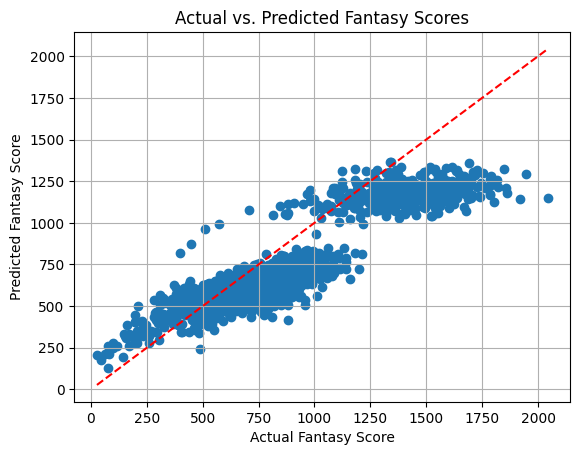

In [106]:
plt.scatter(eval_df['sum_top11_actual'], eval_df['sum_top11_predict'])
plt.plot([eval_df['sum_top11_actual'].min(),eval_df['sum_top11_actual'].max()],[eval_df['sum_top11_actual'].min(),eval_df['sum_top11_actual'].max()],'r--')
plt.xlabel('Actual Fantasy Score')
plt.ylabel('Predicted Fantasy Score')
plt.title('Actual vs. Predicted Fantasy Scores')
plt.grid()
plt.show()

**Validation with SHAP values**

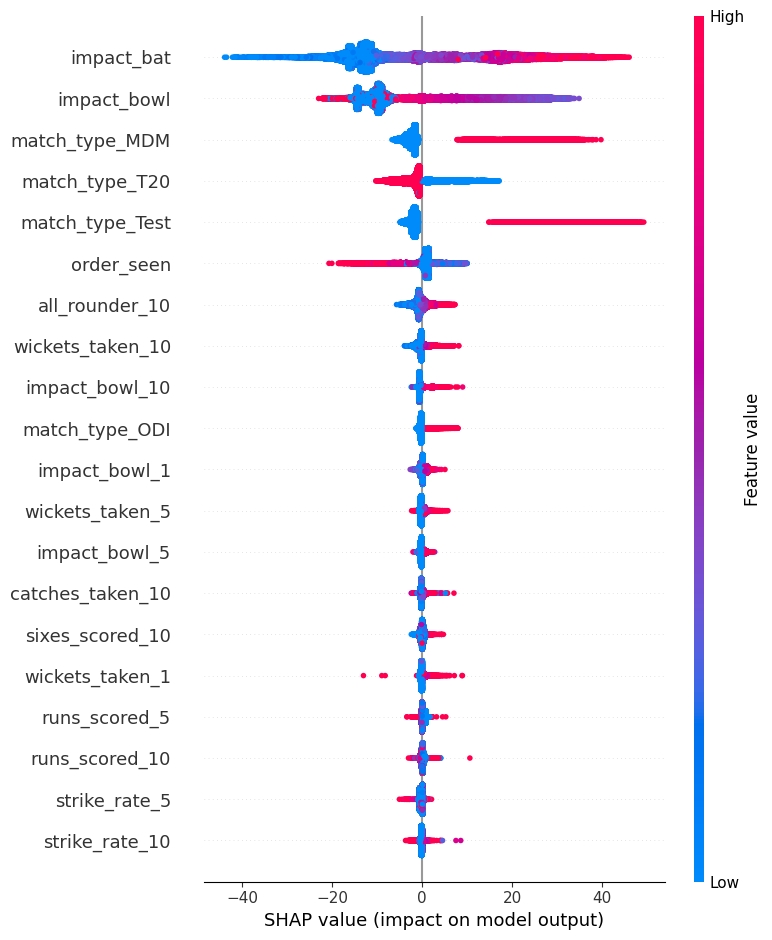

In [107]:
explainer = shap.TreeExplainer(xg)
explain = explainer(X_test)
shap.summary_plot(explain, X_test) #Summary Plot

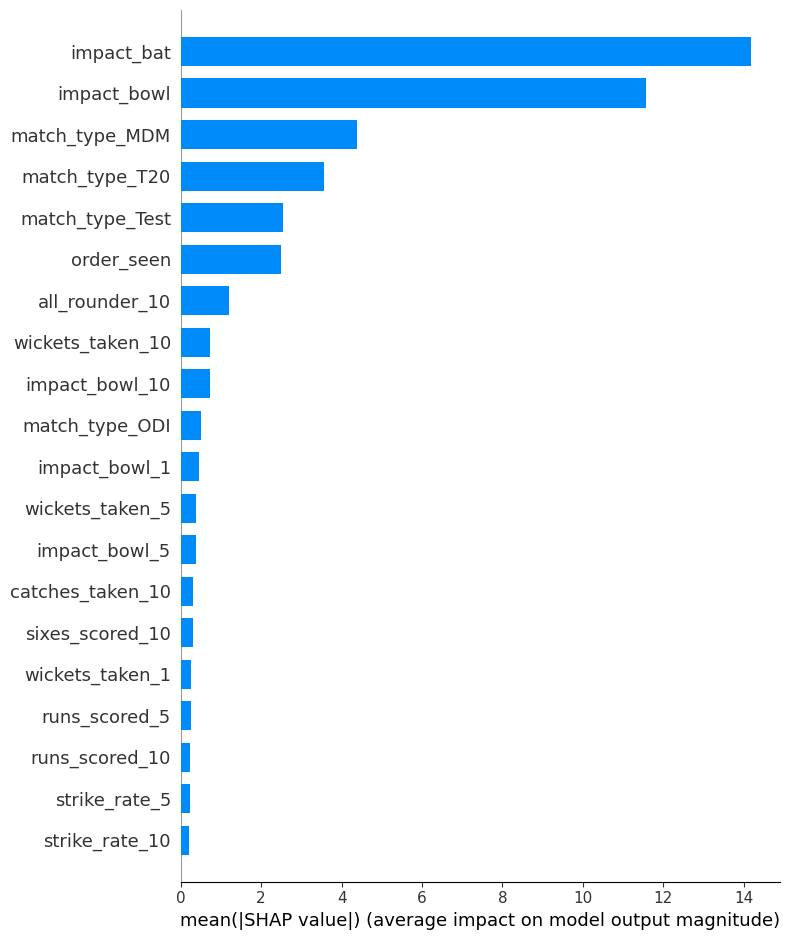

In [108]:
shap.summary_plot(explain,X_test,plot_type='bar') # Mean absolute SHAP values plot

## **Recursive Feature Elimination (with RFECV)**

In [109]:
std = StandardScaler() #Scaling
X_train_scaled = std.fit_transform(X_train)
X_test_scaled = std.transform(X_test)

In [110]:
xg2 = XGBRegressor(n_estimators=500, learning_rate=0.04, max_depth  = 5,random_state = 42)
rfecv = RFECV(estimator=xg2, step=1, cv=5, scoring='neg_mean_squared_error',n_jobs=-1)
rfecv.fit(X_train_scaled, y_train)

RFECV(cv=5,
      estimator=XGBRegressor(base_score=None, booster=None, callbacks=None,
                             colsample_bylevel=None, colsample_bynode=None,
                             colsample_bytree=None, device=None,
                             early_stopping_rounds=None,
                             enable_categorical=False, eval_metric=None,
                             feature_types=None, feature_weights=None,
                             gamma=None, grow_policy=None, importance_type=None,
                             interaction_constraints=None, learning_rate=0.04,
                             max_bin=None, max_cat_threshold=None,
                             max_cat_to_onehot=None, max_delta_step=None,
                             max_depth=5, max_leaves=None,
                             min_child_weight=None, missing=nan,
                             monotone_constraints=None, multi_strategy=None,
                             n_estimators=500, n_jobs=None,
                             num_parallel_tree=None, ...),
      n_jobs=-1, scoring='neg_mean_squared_error')

In [111]:
print(f"Number of optimal features: {rfecv.n_features_}")
print("Selected features:", X_train.columns[rfecv.support_].tolist())

Number of optimal features: 11
Selected features: ['order_seen', 'match_type_MDM', 'match_type_ODI', 'match_type_ODM', 'match_type_T20', 'match_type_Test', 'impact_bat', 'impact_bowl', 'wickets_taken_10', 'all_rounder_10', 'impact_bowl_5']


In [112]:
X_train_sel = rfecv.transform(X_train_scaled)
X_test_sel = rfecv.transform(X_test_scaled)
xg2.fit(X_train_sel, y_train)
predicted_fst_2 = xg2.predict(X_test_sel)
print("RMSE :",mean_squared_error(y_test, predicted_fst_2))
print("R2 Score:", r2_score(y_test, predicted_fst_2))

RMSE : 986.5996704101562
R2 Score: 0.4238583445549011


**Performance Analysis**

In [113]:
df_test['predicted_fst_2'] = predicted_fst_2
df_test

,player_id,match_id,start_date,order_seen,fantasy_score_total,match_type_MDM,match_type_ODI,match_type_ODM,match_type_T20,match_type_Test,...,all_rounder_5,all_rounder_10,impact_bat_1,impact_bat_5,impact_bat_10,impact_bowl_1,impact_bowl_5,impact_bowl_10,predicted_fst,predicted_fst_2
333492,6686,1355634,2023-08-21,0,8,0,0,0,1,0,...,19.143310,19.371102,12.588235,11.909471,0.000000,6.450000,6.075575,6.704745,21.924402,21.271776
333493,6713,1355634,2023-08-21,2,9,0,0,0,1,0,...,11.277770,9.976343,20.071429,12.381189,11.244889,0.000000,0.000000,0.000000,17.793270,20.673748
333494,11401,1393311,2023-08-21,4,85,0,0,0,1,0,...,18.842858,20.188834,6.173913,6.876633,7.019944,0.000000,0.000000,0.000000,60.695557,60.152740
333495,391,1393311,2023-08-21,0,42,0,0,0,1,0,...,13.866873,12.194887,8.571429,0.000000,0.000000,7.437500,6.423762,0.000000,51.737450,49.880016
333496,7481,1355634,2023-08-21,1,23,0,0,0,1,0,...,14.034379,23.076988,10.250000,12.357847,12.411139,0.000000,0.000000,0.000000,43.977154,44.190674
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
416707,1587,1462374,2025-05-20,2,42,0,0,1,0,0,...,11.065393,12.664247,5.923077,6.369151,6.310701,0.000000,0.000000,0.000000,43.985821,46.110592
416708,7111,1462374,2025-05-20,7,96,0,0,1,0,0,...,27.788399,26.730006,10.153846,0.000000,0.000000,3.400000,4.080662,4.468867,73.483208,77.250008
416709,10032,1462374,2025-05-20,8,13,0,0,1,0,0,...,18.496945,16.810381,1.818182,0.000000,0.000000,4.016129,4.928762,5.207377,55.774311,52.141155
416710,10220,1473500,2025-05-20,2,16,0,0,0,1,0,...,9.602657,15.384954,0.000000,5.474121,7.157930,0.000000,0.000000,0.000000,52.983269,48.500816


In [114]:
eval_df = (

    df_test.groupby('match_id').apply(

        lambda x: pd.Series({

            'sum_top11_actual' : x['fantasy_score_total'].nlargest(11).sum(),
            'sum_top11_predict_1' : x['predicted_fst'].nlargest(11).sum(),
            'sum_top11_predict_2' : x['predicted_fst_2'].nlargest(11).sum(),

        })

    ).reset_index()

)
eval_df

,match_id,sum_top11_actual,sum_top11_predict_1,sum_top11_predict_2
0,1336048,643.0,625.639282,608.585693
1,1336049,745.0,656.025818,654.659607
2,1336050,772.0,614.417297,625.149292
3,1336051,697.0,657.206482,656.651855
4,1336052,891.0,721.093811,724.724243
...,...,...,...,...
3755,1484052,762.0,711.147644,705.573425
3756,1485778,649.0,583.248901,585.730408
3757,1486225,846.0,645.032898,662.575378
3758,1486227,688.0,602.258789,594.463135


In [115]:
eval_df['abs_%_error_2'] = (
    (eval_df['sum_top11_predict_2'] - eval_df['sum_top11_actual']).abs() /
    eval_df['sum_top11_actual']
) * 100
eval_df['_%_error_2'] = (
    (eval_df['sum_top11_predict_2'] - eval_df['sum_top11_actual']) /
    eval_df['sum_top11_actual']
) * 100
mean_abs_percentage_error = eval_df['abs_%_error_2'].mean()
mean_percentage_error = eval_df['_%_error_2'].mean()
print(f"Mean Absolute % Error: {mean_abs_percentage_error:.2f}")
print(f"Mean % Error: {mean_percentage_error:.2f}")

Mean Absolute % Error: 17.19
Mean % Error: -11.56


In [116]:
eval_df

,match_id,sum_top11_actual,sum_top11_predict_1,sum_top11_predict_2,abs_%_error_2,_%_error_2
0,1336048,643.0,625.639282,608.585693,5.352147,-5.352147
1,1336049,745.0,656.025818,654.659607,12.126227,-12.126227
2,1336050,772.0,614.417297,625.149292,19.022112,-19.022112
3,1336051,697.0,657.206482,656.651855,5.788830,-5.788830
4,1336052,891.0,721.093811,724.724243,18.661701,-18.661701
...,...,...,...,...,...,...
3755,1484052,762.0,711.147644,705.573425,7.405062,-7.405062
3756,1485778,649.0,583.248901,585.730408,9.748782,-9.748782
3757,1486225,846.0,645.032898,662.575378,21.681397,-21.681397
3758,1486227,688.0,602.258789,594.463135,13.595475,-13.595475


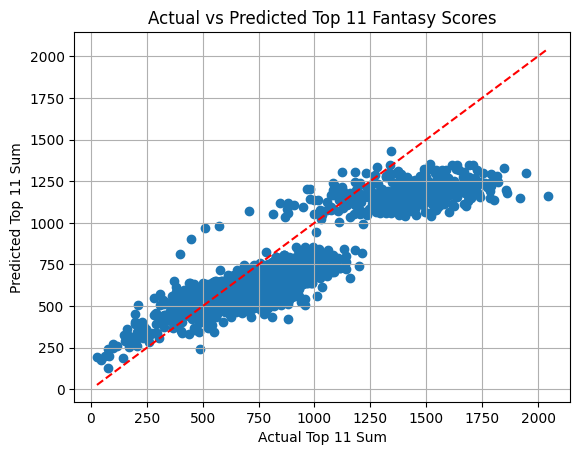

In [117]:
plt.scatter(
    eval_df['sum_top11_actual'],
    eval_df['sum_top11_predict_2'],
)
plt.plot([eval_df['sum_top11_actual'].min(), eval_df['sum_top11_actual'].max()],
         [eval_df['sum_top11_actual'].min(), eval_df['sum_top11_actual'].max()],
         color='red', linestyle='--')

plt.xlabel('Actual Top 11 Sum')
plt.ylabel('Predicted Top 11 Sum')
plt.title('Actual vs Predicted Top 11 Fantasy Scores')

plt.grid()
plt.show()

**Validation with SHAP values**

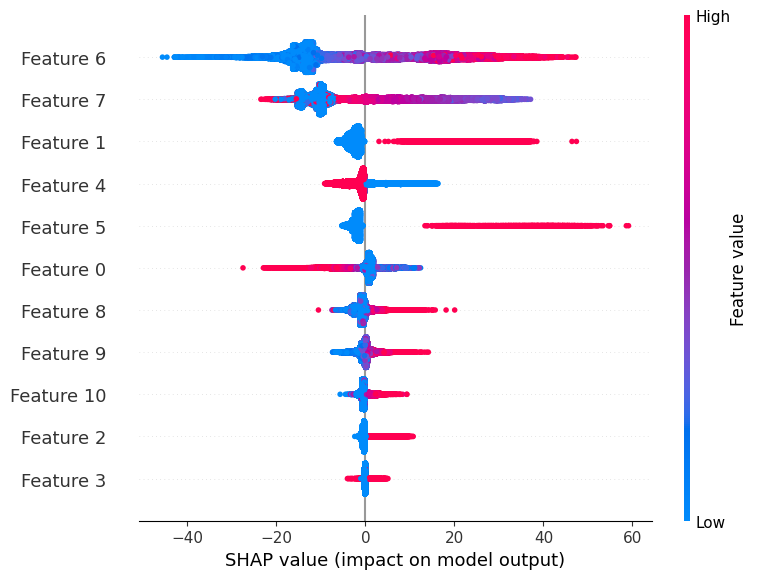

In [118]:
explainer = shap.TreeExplainer(xg2)
explain2 = explainer(X_test_sel)
shap.summary_plot(explain2, X_test_sel) # Summary Plot

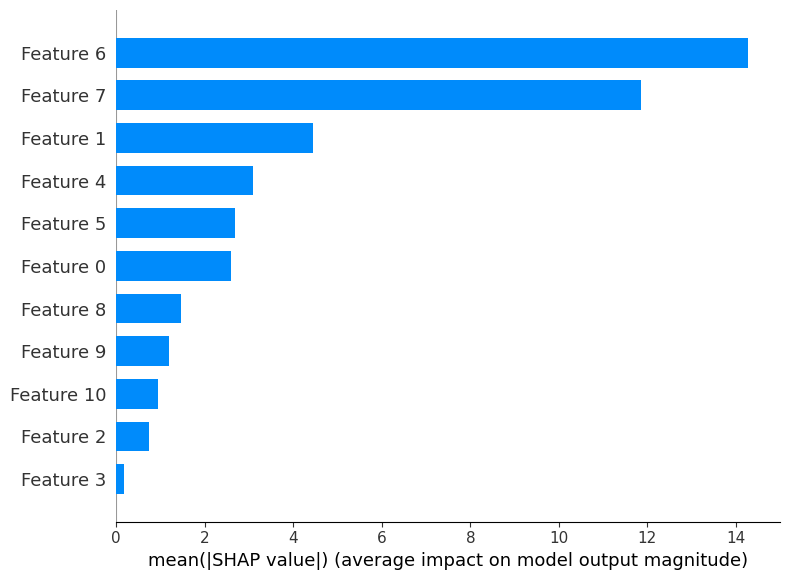

In [119]:
shap.summary_plot(explain2,X_test_sel,plot_type='bar') # Mean absolute SHAP values plot

##**Principal Component Analysis (PCA)**

In [120]:
pca = PCA(n_components=0.8)
X_train_transformed = pca.fit_transform(X_train_scaled)
X_test_transformed = pca.transform(X_test_scaled)
print("Number of components:", pca.n_components_)

Number of components: 15


In [121]:
xg3 = XGBRegressor(n_estimators=500, learning_rate=0.04, max_depth  = 5,random_state = 42)
xg3.fit(X_train_transformed, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.04, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=500,
             n_jobs=None, num_parallel_tree=None, ...)

In [122]:
predict_fst_3 = xg3.predict(X_test_transformed)
print("RMSE :",mean_squared_error(y_test, predict_fst_3))
print("R2 Score:", r2_score(y_test, predict_fst_3))

RMSE : 1302.63720703125
R2 Score: 0.2393028736114502


**Performance Analysis**

In [123]:
df_test['predict_fst_3'] = predict_fst_3
df_test

,player_id,match_id,start_date,order_seen,fantasy_score_total,match_type_MDM,match_type_ODI,match_type_ODM,match_type_T20,match_type_Test,...,all_rounder_10,impact_bat_1,impact_bat_5,impact_bat_10,impact_bowl_1,impact_bowl_5,impact_bowl_10,predicted_fst,predicted_fst_2,predict_fst_3
333492,6686,1355634,2023-08-21,0,8,0,0,0,1,0,...,19.371102,12.588235,11.909471,0.000000,6.450000,6.075575,6.704745,21.924402,21.271776,48.682240
333493,6713,1355634,2023-08-21,2,9,0,0,0,1,0,...,9.976343,20.071429,12.381189,11.244889,0.000000,0.000000,0.000000,17.793270,20.673748,31.936703
333494,11401,1393311,2023-08-21,4,85,0,0,0,1,0,...,20.188834,6.173913,6.876633,7.019944,0.000000,0.000000,0.000000,60.695557,60.152740,55.833900
333495,391,1393311,2023-08-21,0,42,0,0,0,1,0,...,12.194887,8.571429,0.000000,0.000000,7.437500,6.423762,0.000000,51.737450,49.880016,55.899464
333496,7481,1355634,2023-08-21,1,23,0,0,0,1,0,...,23.076988,10.250000,12.357847,12.411139,0.000000,0.000000,0.000000,43.977154,44.190674,47.178680
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
416707,1587,1462374,2025-05-20,2,42,0,0,1,0,0,...,12.664247,5.923077,6.369151,6.310701,0.000000,0.000000,0.000000,43.985821,46.110592,39.666161
416708,7111,1462374,2025-05-20,7,96,0,0,1,0,0,...,26.730006,10.153846,0.000000,0.000000,3.400000,4.080662,4.468867,73.483208,77.250008,53.884529
416709,10032,1462374,2025-05-20,8,13,0,0,1,0,0,...,16.810381,1.818182,0.000000,0.000000,4.016129,4.928762,5.207377,55.774311,52.141155,63.277294
416710,10220,1473500,2025-05-20,2,16,0,0,0,1,0,...,15.384954,0.000000,5.474121,7.157930,0.000000,0.000000,0.000000,52.983269,48.500816,55.372837


In [124]:
eval_df = (

    df_test.groupby('match_id').apply(

        lambda x: pd.Series({

            'sum_top11_actual' : x['fantasy_score_total'].nlargest(11).sum(),
            'sum_top11_predict_1' : x['predicted_fst'].nlargest(11).sum(),
            'sum_top11_predict_2' : x['predicted_fst_2'].nlargest(11).sum(),
            'sum_top11_predict_3' : x['predict_fst_3'].nlargest(11).sum(),

        })

    ).reset_index()

)
eval_df

,match_id,sum_top11_actual,sum_top11_predict_1,sum_top11_predict_2,sum_top11_predict_3
0,1336048,643.0,625.639282,608.585693,552.240662
1,1336049,745.0,656.025818,654.659607,561.429260
2,1336050,772.0,614.417297,625.149292,544.677185
3,1336051,697.0,657.206482,656.651855,548.585571
4,1336052,891.0,721.093811,724.724243,584.421753
...,...,...,...,...,...
3755,1484052,762.0,711.147644,705.573425,584.799377
3756,1485778,649.0,583.248901,585.730408,423.401520
3757,1486225,846.0,645.032898,662.575378,458.143555
3758,1486227,688.0,602.258789,594.463135,458.444122


In [125]:
eval_df['abs_%_error_3'] = (
    (eval_df['sum_top11_predict_3'] - eval_df['sum_top11_actual']).abs() /
    eval_df['sum_top11_actual']
) * 100
eval_df['_%_error_3'] = (
    (eval_df['sum_top11_predict_3'] - eval_df['sum_top11_actual']) /
    eval_df['sum_top11_actual']
) * 100
mean_abs_percentage_error = eval_df['abs_%_error_3'].mean()
mean_percentage_error = eval_df['_%_error_3'].mean()
print(f"Mean Absolute % Error: {mean_abs_percentage_error:.2f}")
print(f"Mean % Error: {mean_percentage_error:.2f}")

Mean Absolute % Error: 26.46
Mean % Error: -19.63


In [126]:
eval_df

,match_id,sum_top11_actual,sum_top11_predict_1,sum_top11_predict_2,sum_top11_predict_3,abs_%_error_3,_%_error_3
0,1336048,643.0,625.639282,608.585693,552.240662,14.114983,-14.114983
1,1336049,745.0,656.025818,654.659607,561.429260,24.640368,-24.640368
2,1336050,772.0,614.417297,625.149292,544.677185,29.445960,-29.445960
3,1336051,697.0,657.206482,656.651855,548.585571,21.293318,-21.293318
4,1336052,891.0,721.093811,724.724243,584.421753,34.408333,-34.408333
...,...,...,...,...,...,...,...
3755,1484052,762.0,711.147644,705.573425,584.799377,23.254675,-23.254675
3756,1485778,649.0,583.248901,585.730408,423.401520,34.760937,-34.760937
3757,1486225,846.0,645.032898,662.575378,458.143555,45.845916,-45.845916
3758,1486227,688.0,602.258789,594.463135,458.444122,33.365680,-33.365680


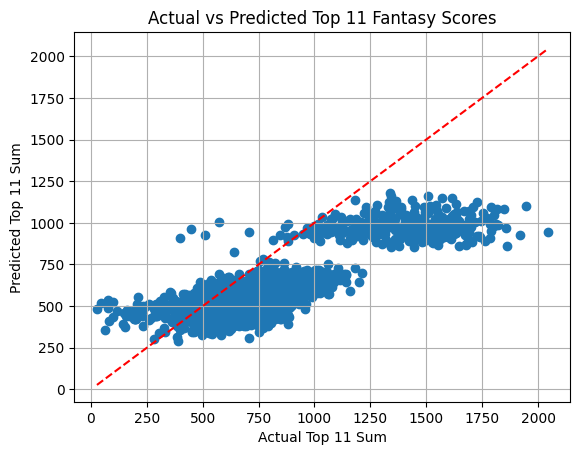

In [127]:
plt.scatter(
    eval_df['sum_top11_actual'],
    eval_df['sum_top11_predict_3'],
)
plt.plot([eval_df['sum_top11_actual'].min(), eval_df['sum_top11_actual'].max()],
         [eval_df['sum_top11_actual'].min(), eval_df['sum_top11_actual'].max()],
         color='red', linestyle='--')

plt.xlabel('Actual Top 11 Sum')
plt.ylabel('Predicted Top 11 Sum')
plt.title('Actual vs Predicted Top 11 Fantasy Scores')

plt.grid()
plt.show()

**Validation with SHAP values**

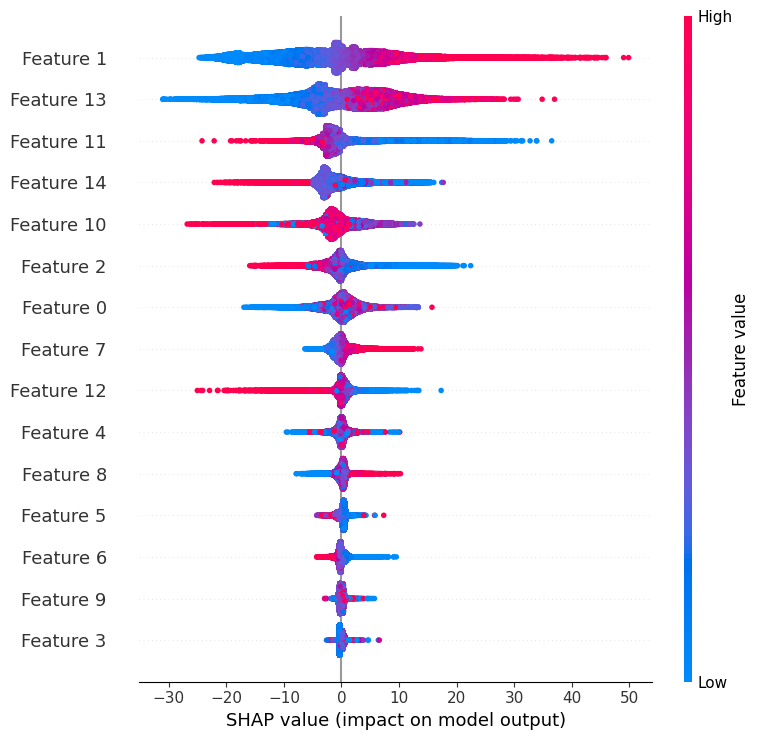

In [128]:
explainer = shap.TreeExplainer(xg3) #Summary Plot
extent3= explainer.shap_values(X_test_transformed)
shap.summary_plot(extent3, X_test_transformed)

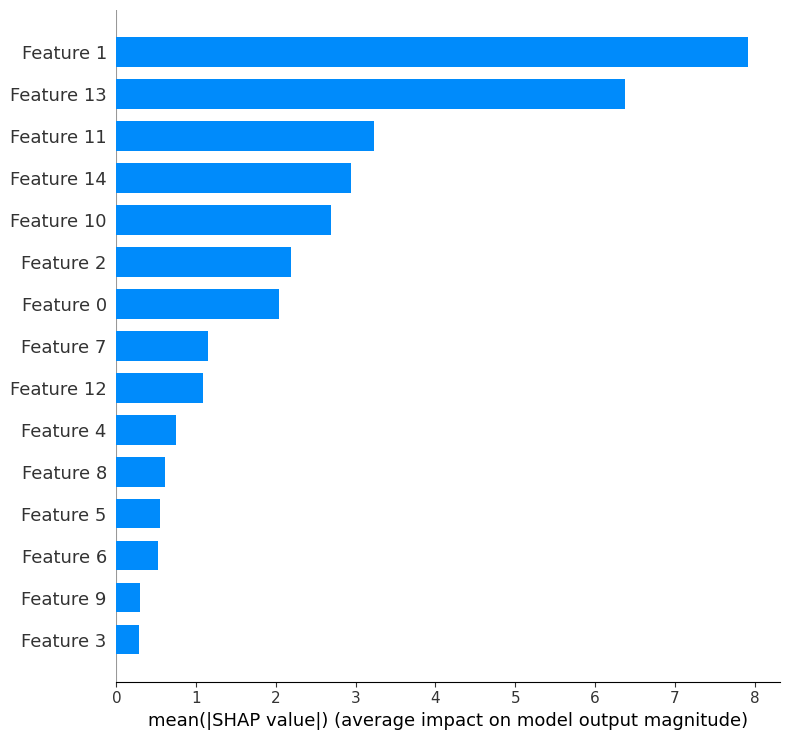

In [129]:
shap.summary_plot(extent3,X_test_transformed,plot_type='bar') # Mean absolute SHAP values plot

## **Week 4 Additions**
$>$ **MAE function (basically loss function) to calculate the sum of absolute error for each player in the top 11 sum**


$>$ **MAE to be not more than 25%** $:($

In [130]:
df_test

,player_id,match_id,start_date,order_seen,fantasy_score_total,match_type_MDM,match_type_ODI,match_type_ODM,match_type_T20,match_type_Test,...,all_rounder_10,impact_bat_1,impact_bat_5,impact_bat_10,impact_bowl_1,impact_bowl_5,impact_bowl_10,predicted_fst,predicted_fst_2,predict_fst_3
333492,6686,1355634,2023-08-21,0,8,0,0,0,1,0,...,19.371102,12.588235,11.909471,0.000000,6.450000,6.075575,6.704745,21.924402,21.271776,48.682240
333493,6713,1355634,2023-08-21,2,9,0,0,0,1,0,...,9.976343,20.071429,12.381189,11.244889,0.000000,0.000000,0.000000,17.793270,20.673748,31.936703
333494,11401,1393311,2023-08-21,4,85,0,0,0,1,0,...,20.188834,6.173913,6.876633,7.019944,0.000000,0.000000,0.000000,60.695557,60.152740,55.833900
333495,391,1393311,2023-08-21,0,42,0,0,0,1,0,...,12.194887,8.571429,0.000000,0.000000,7.437500,6.423762,0.000000,51.737450,49.880016,55.899464
333496,7481,1355634,2023-08-21,1,23,0,0,0,1,0,...,23.076988,10.250000,12.357847,12.411139,0.000000,0.000000,0.000000,43.977154,44.190674,47.178680
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
416707,1587,1462374,2025-05-20,2,42,0,0,1,0,0,...,12.664247,5.923077,6.369151,6.310701,0.000000,0.000000,0.000000,43.985821,46.110592,39.666161
416708,7111,1462374,2025-05-20,7,96,0,0,1,0,0,...,26.730006,10.153846,0.000000,0.000000,3.400000,4.080662,4.468867,73.483208,77.250008,53.884529
416709,10032,1462374,2025-05-20,8,13,0,0,1,0,0,...,16.810381,1.818182,0.000000,0.000000,4.016129,4.928762,5.207377,55.774311,52.141155,63.277294
416710,10220,1473500,2025-05-20,2,16,0,0,0,1,0,...,15.384954,0.000000,5.474121,7.157930,0.000000,0.000000,0.000000,52.983269,48.500816,55.372837


In [131]:
df_test.isnull().sum()

player_id              0
match_id               0
start_date             0
order_seen             0
fantasy_score_total    0
                      ..
impact_bowl_5          0
impact_bowl_10         0
predicted_fst          0
predicted_fst_2        0
predict_fst_3          0
Length: 63, dtype: int64

In [155]:
def MAE_custom(predicted_col,actual_col):
  df_pred = pd.DataFrame({
        'predicted': predicted_col
    })
  df_actual = pd.DataFrame({
        'actual': actual_col
    })
  top11_actual = df_actual.sort_values(by='actual', ascending=False).head(11)
  top11_predicted = df_pred.sort_values(by='predicted', ascending=False).head(11)
  top11 = pd.concat([top11_actual, top11_predicted], axis=1)
  top11 = top11.dropna()
  top11 = top11.reset_index(drop=True)
  mape = (np.abs((top11['actual'] - top11['predicted']))).sum()
  return mape

In [156]:
eval_df = (

    df_test.groupby('match_id').apply(

        lambda x: pd.Series({

            'sum_top11_actual' : x['fantasy_score_total'].nlargest(11).sum(),
            'sum_top11_predict_1' : x['predicted_fst'].nlargest(11).sum(),
            'sum_top11_predict_2' : x['predicted_fst_2'].nlargest(11).sum(),
            'sum_top11_predict_3' : x['predict_fst_3'].nlargest(11).sum(),

        })

    ).reset_index()

)
eval_df

,match_id,sum_top11_actual,sum_top11_predict_1,sum_top11_predict_2,sum_top11_predict_3
0,1336048,643.0,625.639282,608.585693,552.240662
1,1336049,745.0,656.025818,654.659607,561.429260
2,1336050,772.0,614.417297,625.149292,544.677185
3,1336051,697.0,657.206482,656.651855,548.585571
4,1336052,891.0,721.093811,724.724243,584.421753
...,...,...,...,...,...
3755,1484052,762.0,711.147644,705.573425,584.799377
3756,1485778,649.0,583.248901,585.730408,423.401520
3757,1486225,846.0,645.032898,662.575378,458.143555
3758,1486227,688.0,602.258789,594.463135,458.444122


In [157]:
eval_df['mae_custom_1'] = eval_df['match_id'].map(
    df_test.groupby('match_id').apply(
        lambda x: MAE_custom(x['predicted_fst'], x['fantasy_score_total'])
    )
)

eval_df['mae_custom_2'] = eval_df['match_id'].map(
    df_test.groupby('match_id').apply(
        lambda x: MAE_custom(x['predicted_fst_2'], x['fantasy_score_total'])
    )
)

eval_df['mae_custom_3'] = eval_df['match_id'].map(
    df_test.groupby('match_id').apply(
        lambda x: MAE_custom(x['predict_fst_3'], x['fantasy_score_total'])
    )
)

In [158]:
eval_df

,match_id,sum_top11_actual,sum_top11_predict_1,sum_top11_predict_2,sum_top11_predict_3,mae_custom_1,mae_custom_2,mae_custom_3
0,1336048,643.0,625.639282,608.585693,552.240662,138.855492,129.552807,92.822132
1,1336049,745.0,656.025818,654.659607,561.429260,134.620220,224.406712,154.482002
2,1336050,772.0,614.417297,625.149292,544.677185,232.694992,180.929035,178.780594
3,1336051,697.0,657.206482,656.651855,548.585571,97.695194,99.673634,127.729427
4,1336052,891.0,721.093811,724.724243,584.421753,292.891296,283.202053,75.024017
...,...,...,...,...,...,...,...,...
3755,1484052,762.0,711.147644,705.573425,584.799377,110.060719,109.962193,176.015732
3756,1485778,649.0,583.248901,585.730408,423.401520,264.345337,270.887749,191.973145
3757,1486225,846.0,645.032898,662.575378,458.143555,244.905025,236.513828,334.143457
3758,1486227,688.0,602.258789,594.463135,458.444122,263.354435,268.174580,328.909576


In [159]:
eval_df['abs_%_error_1_custom'] = (
    (eval_df['mae_custom_1'] /
    eval_df['sum_top11_actual']
) * 100
)
eval_df['abs_%_error_2_custom'] = (
    (eval_df['mae_custom_2'] /
    eval_df['sum_top11_actual']
) * 100
)
eval_df['abs_%_error_3_custom'] = (
    (eval_df['mae_custom_3'] /
    eval_df['sum_top11_actual']
) * 100
)
eval_df.drop(['mae_custom_1','mae_custom_2','mae_custom_3'],axis=1,inplace=True)

In [160]:
eval_df

,match_id,sum_top11_actual,sum_top11_predict_1,sum_top11_predict_2,sum_top11_predict_3,abs_%_error_1_custom,abs_%_error_2_custom,abs_%_error_3_custom
0,1336048,643.0,625.639282,608.585693,552.240662,21.594944,20.148181,14.435790
1,1336049,745.0,656.025818,654.659607,561.429260,18.069828,30.121706,20.735839
2,1336050,772.0,614.417297,625.149292,544.677185,30.141838,23.436404,23.158108
3,1336051,697.0,657.206482,656.651855,548.585571,14.016527,14.300378,18.325599
4,1336052,891.0,721.093811,724.724243,584.421753,32.872199,31.784742,8.420204
...,...,...,...,...,...,...,...,...
3755,1484052,762.0,711.147644,705.573425,584.799377,14.443664,14.430734,23.099177
3756,1485778,649.0,583.248901,585.730408,423.401520,40.731177,41.739252,29.579837
3757,1486225,846.0,645.032898,662.575378,458.143555,28.948585,27.956717,39.496863
3758,1486227,688.0,602.258789,594.463135,458.444122,38.278261,38.978863,47.806624


In [161]:
print("Mean absolute percentage arror for all matches for the given loss function for model 1:",eval_df['abs_%_error_1_custom'].mean())
print("Mean absolute percentage arror for all matches for the given loss function for model 2:",eval_df['abs_%_error_2_custom'].mean())
print("Mean absolute percentage arror for all matches for the given loss function for model 3:",eval_df['abs_%_error_3_custom'].mean())

Mean absolute percentage arror for all matches for the given loss function for model 1: 29.460398388694287
Mean absolute percentage arror for all matches for the given loss function for model 2: 29.42465005219528
Mean absolute percentage arror for all matches for the given loss function for model 3: 28.756714651007538


### **Applying PSO**

In [139]:
bounds = ([0.01,3,50,0.3,0.2,0.1,0.1],
          [0.2,10,1000,1.0,1.0,10,10])
def obj_func(paras):
    scores = []
    for p in paras:
        model = XGBRegressor(
            learning_rate=p[0],
            max_depth=int(p[1]),
            n_estimators=int(p[2]),
            subsample=p[3],
            colsample_bytree=p[4],
            reg_alpha=p[5],
            reg_lambda=p[6],
            objective='reg:squarederror',
            random_state=42,
            n_jobs=-1,
            verbosity=0
        )
        score = cross_val_score(model, X_train, y_train, cv=4, scoring='neg_root_mean_squared_error').mean()
        scores.append(-score)
    return np.array(scores)

In [140]:
optimizer = GlobalBestPSO(
    n_particles=20,
    dimensions=7,
    options={'c1': 0.7, 'c2': 0.4, 'w': 0.85},
    bounds=bounds
    )

In [141]:
best_val,best_para = optimizer.optimize(obj_func,iters=20)

2025-06-24 21:57:48,932 - pyswarms.single.global_best - INFO - Optimize for 20 iters with {'c1': 0.7, 'c2': 0.4, 'w': 0.85}
pyswarms.single.global_best: 100%|██████████|20/20, best_cost=33.1
2025-06-25 00:23:21,394 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 33.130863189697266, best pos: [1.51116594e-02 8.06592482e+00 6.77885955e+02 7.51004454e-01
 6.84321110e-01 6.04162674e+00 7.91887208e+00]


In [142]:
print("\nBest hyperparameters found so far by PSO:")
print(f"Learning Rate: {best_para[0]:.4f}")
print(f"Max Depth: {int(best_para[1])}")
print(f"N Estimators: {int(best_para[2])}")
print(f"Subsample: {best_para[3]:.2f}")
print(f"Colsample_bytree: {best_para[4]:.2f}")
print(f"Reg_alpha: {best_para[5]:.3f}")
print(f"Reg_lambda: {best_para[6]:.3f}")


Best hyperparameters found so far by PSO:
Learning Rate: 0.0151
Max Depth: 8
N Estimators: 677
Subsample: 0.75
Colsample_bytree: 0.68
Reg_alpha: 6.042
Reg_lambda: 7.919


###**Applying XGBoost after PSO**

In [143]:
xg4 = XGBRegressor(
    learning_rate=best_para[0],
    max_depth=int(best_para[1]),
    n_estimators=int(best_para[2]),
    subsample=best_para[3],
    colsample_bytree=best_para[4],
    reg_alpha=best_para[5],
    reg_lambda= best_para[6],
    objective='reg:squarederror',
    random_state=42,
    n_jobs=-1,
    verbosity=0
)

rfe_selector = RFECV(estimator=xg4, step=1,cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
rfe_selector = rfe_selector.fit(X_train, y_train)


print(f"Number of optimal features: {rfecv.n_features_}")
print("Selected features:", X_train.columns[rfecv.support_].tolist())

X_train_rfe = rfe_selector.transform(X_train)
X_test_rfe = rfe_selector.transform(X_test)
xg4.fit(X_train_rfe, y_train)
predicted_fst_4 = xg4.predict(X_test_rfe)
df_test['predicted_fst_4'] = predicted_fst_4

Number of optimal features: 11
Selected features: ['order_seen', 'match_type_MDM', 'match_type_ODI', 'match_type_ODM', 'match_type_T20', 'match_type_Test', 'impact_bat', 'impact_bowl', 'wickets_taken_10', 'all_rounder_10', 'impact_bowl_5']


In [144]:
print("RMSE :",mean_squared_error(y_test, predicted_fst_4))
print("R2 Score:", r2_score(y_test, predicted_fst_4))

RMSE : 978.01416015625
R2 Score: 0.4288719892501831


In [145]:
df_test

,player_id,match_id,start_date,order_seen,fantasy_score_total,match_type_MDM,match_type_ODI,match_type_ODM,match_type_T20,match_type_Test,...,impact_bat_1,impact_bat_5,impact_bat_10,impact_bowl_1,impact_bowl_5,impact_bowl_10,predicted_fst,predicted_fst_2,predict_fst_3,predicted_fst_4
333492,6686,1355634,2023-08-21,0,8,0,0,0,1,0,...,12.588235,11.909471,0.000000,6.450000,6.075575,6.704745,21.924402,21.271776,48.682240,21.477844
333493,6713,1355634,2023-08-21,2,9,0,0,0,1,0,...,20.071429,12.381189,11.244889,0.000000,0.000000,0.000000,17.793270,20.673748,31.936703,19.092859
333494,11401,1393311,2023-08-21,4,85,0,0,0,1,0,...,6.173913,6.876633,7.019944,0.000000,0.000000,0.000000,60.695557,60.152740,55.833900,59.167465
333495,391,1393311,2023-08-21,0,42,0,0,0,1,0,...,8.571429,0.000000,0.000000,7.437500,6.423762,0.000000,51.737450,49.880016,55.899464,51.185959
333496,7481,1355634,2023-08-21,1,23,0,0,0,1,0,...,10.250000,12.357847,12.411139,0.000000,0.000000,0.000000,43.977154,44.190674,47.178680,42.188366
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
416707,1587,1462374,2025-05-20,2,42,0,0,1,0,0,...,5.923077,6.369151,6.310701,0.000000,0.000000,0.000000,43.985821,46.110592,39.666161,46.491001
416708,7111,1462374,2025-05-20,7,96,0,0,1,0,0,...,10.153846,0.000000,0.000000,3.400000,4.080662,4.468867,73.483208,77.250008,53.884529,71.330040
416709,10032,1462374,2025-05-20,8,13,0,0,1,0,0,...,1.818182,0.000000,0.000000,4.016129,4.928762,5.207377,55.774311,52.141155,63.277294,55.024384
416710,10220,1473500,2025-05-20,2,16,0,0,0,1,0,...,0.000000,5.474121,7.157930,0.000000,0.000000,0.000000,52.983269,48.500816,55.372837,49.997051


In [146]:
eval_df = (

    df_test.groupby('match_id').apply(

        lambda x: pd.Series({

            'sum_top11_actual' : x['fantasy_score_total'].nlargest(11).sum(),
            'sum_top11_predict_1' : x['predicted_fst'].nlargest(11).sum(),
            'sum_top11_predict_2' : x['predicted_fst_2'].nlargest(11).sum(),
            'sum_top11_predict_3' : x['predict_fst_3'].nlargest(11).sum(),
            'sum_top11_predict_4' : x['predicted_fst_4'].nlargest(11).sum(),

        })

    ).reset_index()

)
eval_df

,match_id,sum_top11_actual,sum_top11_predict_1,sum_top11_predict_2,sum_top11_predict_3,sum_top11_predict_4
0,1336048,643.0,625.639282,608.585693,552.240662,608.380127
1,1336049,745.0,656.025818,654.659607,561.429260,656.973755
2,1336050,772.0,614.417297,625.149292,544.677185,606.999573
3,1336051,697.0,657.206482,656.651855,548.585571,649.096558
4,1336052,891.0,721.093811,724.724243,584.421753,701.548584
...,...,...,...,...,...,...
3755,1484052,762.0,711.147644,705.573425,584.799377,709.108582
3756,1485778,649.0,583.248901,585.730408,423.401520,579.209778
3757,1486225,846.0,645.032898,662.575378,458.143555,650.955872
3758,1486227,688.0,602.258789,594.463135,458.444122,599.554016


In [147]:
eval_df['abs_%_error_4'] = (
    (eval_df['sum_top11_predict_4'] - eval_df['sum_top11_actual']).abs() /
    eval_df['sum_top11_actual']
) * 100
eval_df['_%_error_4'] = (
    (eval_df['sum_top11_predict_4'] - eval_df['sum_top11_actual']) /
    eval_df['sum_top11_actual']
) * 100
mean_abs_percentage_error = eval_df['abs_%_error_4'].mean()
mean_percentage_error = eval_df['_%_error_4'].mean()
print(f"Mean Absolute % Error: {mean_abs_percentage_error:.2f}")
print(f"Mean % Error: {mean_percentage_error:.2f}")

Mean Absolute % Error: 17.29
Mean % Error: -11.73


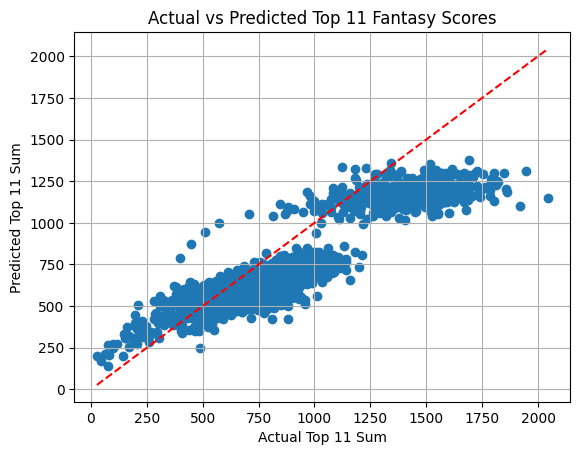

In [148]:
plt.scatter(
    eval_df['sum_top11_actual'],
    eval_df['sum_top11_predict_4'],
)
plt.plot([eval_df['sum_top11_actual'].min(), eval_df['sum_top11_actual'].max()],
         [eval_df['sum_top11_actual'].min(), eval_df['sum_top11_actual'].max()],
         color='red', linestyle='--')

plt.xlabel('Actual Top 11 Sum')
plt.ylabel('Predicted Top 11 Sum')
plt.title('Actual vs Predicted Top 11 Fantasy Scores')

plt.grid()
plt.show()

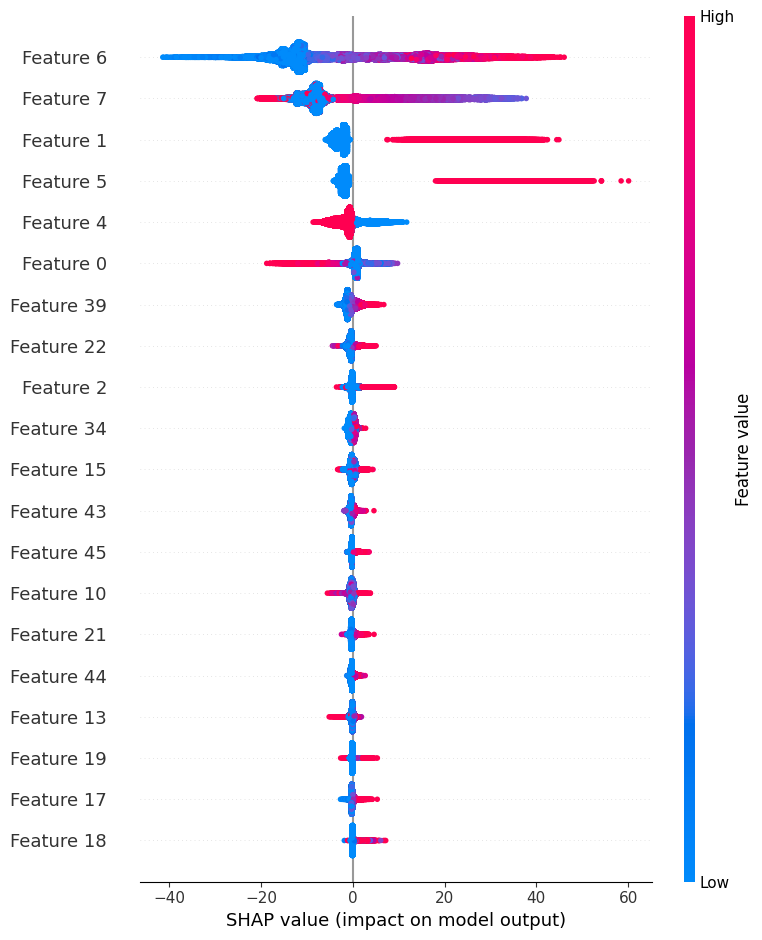

In [149]:
explainer = shap.TreeExplainer(xg4) #Summary Plot
extent4 = explainer.shap_values(X_test_rfe)
shap.summary_plot(extent4, X_test_rfe)

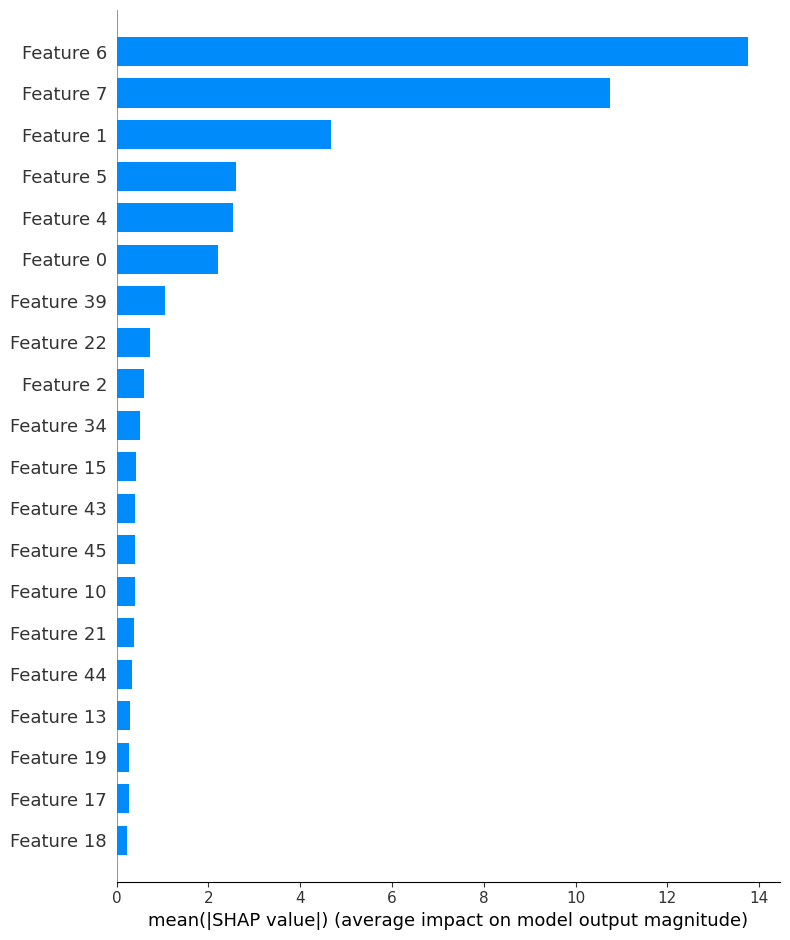

In [150]:
shap.summary_plot(extent4,X_test_rfe,plot_type='bar') # Mean absolute SHAP values plot